# Anchovy eDNA vs Acoustic Strength

In [8]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#Directory for saving Figures
plot_dir = '../figures/Anchovy_Acoustic/'
print(plot_dir)

levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']


../figures/Anchovy_Acoustic/


### Import Filtered Data (from previous Jupyter notebook)

In [3]:
#location of data:
directory = '../data/filtered_seq_data/'
markers = ['12S']

otus= []
taxas=[]
metas=[]
for marker in markers:
    print('XXXXXX    ',marker)
    df = pd.read_csv(directory+'CN19S_'+marker+'_otu_Filtered.csv')
    df = df.rename(columns={'Unnamed: 0':'ASV'})
    df.set_index('ASV', inplace=True)
    otus.append(df)
    print('Number samples in otu_table:', len(list(df)))
    df = pd.read_csv(directory+'CN19S_'+marker+'_meta_Filtered.csv')
    df.set_index('sample_name', inplace=True)
    #date handling
    print(list(df))
    df['eventDate'] = pd.to_datetime(df['eventDate'])
    df['month'] = df['eventDate'].dt.month
    metas.append(df)
    print('Number samples in metadata table:', len(df.index))
    df = pd.read_csv(directory+'CN19S_'+marker+'_taxa_Filtered.csv')
    df = df.rename(columns={'Unnamed: 0':'ASV'})
    df.set_index('ASV', inplace=True)
    print('Number ASVs in taxa table:', len(df.index))
    taxas.append(df)
taxas[0].head()

XXXXXX     12S
Number samples in otu_table: 223
['FilterID', 'target_gene', 'PlateID', 'library', 'local_time', 'time_label', 'SAMPLING_cruise', 'depth', 'SAMPLING_platform', 'SC', 'ESP', 'SAMPLING_station_number', 'SAMPLING_station', 'SAMPLING_bottle', 'decimalLongitude', 'decimalLatitude', 'sample_type', 'Plates', 'Markers', 'Status', 'Dewar_name', 'Sampling_method', 'replicate', 'SAMPLING_rdepth', 'project_name', 'nitrate', 'fluor', 'density', 'pressure', 'minimumDepthInMeters', 'maximumDepthInMeters', 'start_GMT', 'end_GMT', 'temp', 'salinity', 'sigmat', 'spice', 'diss_oxygen', 'PAR (umol/s/m2)', 'altitude', 'chlorophyll', 'bbp470 (count)', 'bbp650 (count)', 'SAMPLING_project', 'ESP_name', 'diel', 'month', 'day', 'hour', 'eventDate']
Number samples in metadata table: 223
Number ASVs in taxa table: 450


,Kingdom,Phylum,Class,Order,Family,Genus,Species
ASV,,,,,,,
ASV_1,Eukaryota,Chordata,Actinopteri,Clupeiformes,Engraulidae,Engraulis,Engraulis mordax
ASV_4,Eukaryota,Chordata,Actinopteri,Gadiformes,Macrouridae,Coryphaenoides,unassigned
ASV_8,Eukaryota,Chordata,Actinopteri,Argentiniformes,Bathylagidae,Bathylagus,Bathylagus pacificus
ASV_12,Eukaryota,Chordata,Actinopteri,Argentiniformes,Bathylagidae,Leuroglossus,Leuroglossus schmidti
ASV_13,Eukaryota,Chordata,Actinopteri,Gadiformes,Merlucciidae,Merluccius,Merluccius productus


### Import Acoustic Data

In [4]:
# CTD
file = '../data/DEIMOS/WF_eDNA_acoustics.csv'
df = pd.read_csv(file)
df.set_index('FilterID', inplace=True)
DEIM = df.copy()
df.head()

,Average sampled energy,Percent total sampled
FilterID,,
CN19Sc03_10_eDNA,3.992650e-04,1.05
CN19Sc03_09_eDNA,2.234680e-07,0.00
CN19Sc03_07_eDNA,5.868500e-07,0.00
CN19Sc03_05_eDNA,4.356320e-07,0.00
CN19Sc03_04_eDNA,7.256560e-07,0.00


In [5]:
# LRAUV
file = '../data/DEIMOS/LRAUV_eDNA_acoustics.csv'
df = pd.read_csv(file)
df.set_index('FilterID', inplace=True)
DEIM_LRAUV = df.copy()
df.head()


,sample,Sampled depth acoustic energy,Total acoustic energy,Percent of total energy samples,Unnamed: 5
FilterID,,,,,
CN19SESPMV1_SC05_eDNA,1,7.595200e-07,0.000515,0.15,NaN
CN19SESPMV1_SC04_eDNA,2,1.164360e-05,0.021107,0.06,NaN
CN19SESPMV1_SC03_eDNA,3,3.934580e-05,0.000634,6.21,NaN
CN19SESPMV1_SC58_eDNA,4,1.665825e-03,0.004988,33.40,NaN
CN19SESPKOA_SC58_eDNA,5,9.196670e-05,0.000495,18.59,NaN


### Merge Acoustic and eDNA information

In [19]:
#eDNA reads - just Anchovy 
print(markers[0])
levels = list(taxas[0])
df = pd.concat([otus[0], taxas[0]], axis=1)
#sum all fish and shark reads
df = df.loc[df['Genus'].isin(['Engraulis'])==True]
df = df.groupby('Genus').sum()

df = df.T
df = pd.concat([df, metas[0][['depth', 'FilterID']]], axis=1)
df = df.join(DEIM, on='FilterID')
df

12S


,Engraulis,depth,FilterID,Average sampled energy,Percent total sampled
sample_name,,,,,
CN19Sc29_12_eDNA_RR,26339,0.0,CN19Sc29_12_eDNA,9.481260e-05,21.01
CN19Sc29_11_eDNA_RR,31308,40.0,CN19Sc29_11_eDNA,3.476070e-07,0.08
CN19Sc29_10_eDNA_RR,11057,80.0,CN19Sc29_10_eDNA,2.494630e-07,0.06
CN19Sc29_9_eDNA_RR,21931,110.0,CN19Sc29_09_eDNA,4.221480e-07,0.09
CN19Sc29_8_eDNA_RR,13576,165.0,CN19Sc29_08_eDNA,1.087480e-06,0.24
...,...,...,...,...,...
CN19Sc02_12_eDNA_JJ,10743,0.0,CN19Sc02_12_eDNA,NaN,NaN
CN19Sc04_12_eDNA_JJ,19899,0.0,CN19Sc04_12_eDNA,NaN,NaN
CN19Sc22_8_eDNA_JJ,23374,55.0,CN19Sc22_08_eDNA,NaN,NaN


# Compare Acoustic Data to Anchovy eDNA Reads

12S
['Average sampled energy', 'Percent total sampled']


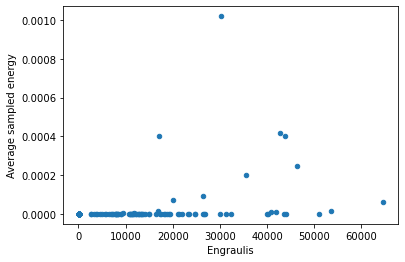

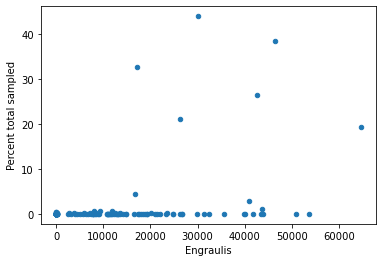

,Engraulis,depth,FilterID,Average sampled energy,Percent total sampled
sample_name,,,,,
CN19Sc29_12_eDNA_RR,26339,0.0,CN19Sc29_12_eDNA,9.481260e-05,21.01
CN19Sc29_11_eDNA_RR,31308,40.0,CN19Sc29_11_eDNA,3.476070e-07,0.08
CN19Sc29_10_eDNA_RR,11057,80.0,CN19Sc29_10_eDNA,2.494630e-07,0.06
CN19Sc29_9_eDNA_RR,21931,110.0,CN19Sc29_09_eDNA,4.221480e-07,0.09
CN19Sc29_8_eDNA_RR,13576,165.0,CN19Sc29_08_eDNA,1.087480e-06,0.24


In [18]:
# Direct Plot

print(markers[0])
levels = list(taxas[0])
df = pd.concat([otus[0], taxas[0]], axis=1)
#sum all fish and shark reads
df = df.loc[df['Genus'].isin(['Engraulis'])==True]
df = df.groupby('Genus').sum()

df = df.T
df = pd.concat([df, metas[0][['depth', 'FilterID']]], axis=1)
df = df.join(DEIM, on='FilterID')
print(list(DEIM))
df = df.loc[df['Average sampled energy'].isna()==False]

df.plot(kind='scatter', y='Average sampled energy', x='Engraulis' )
plt.show()

df.plot(kind='scatter', y='Percent total sampled', x='Engraulis' )
plt.show()
df.head()

12S
['Average sampled energy', 'Percent total sampled']
R-squared: 0.265376
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_logavg.pdf


<ipython-input-11-e6028db43737>:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-11-e6028db43737>:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


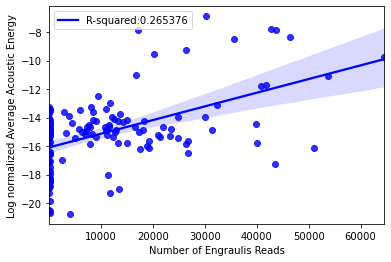

In [11]:
print(markers[0])
levels = list(taxas[0])
df = pd.concat([otus[0], taxas[0]], axis=1)
#sum all fish and shark reads
#df = df.loc[df['Class'].isin(['Actinopteri', 'Chondrichthyes'])]
df = df.loc[df['Genus'].isin(['Engraulis'])==True]
df = df.groupby('Genus').sum()


df = df.T
df = pd.concat([df, metas[0][['depth', 'FilterID']]], axis=1)
df = df.join(DEIM, on='FilterID')
print(list(DEIM))
df = df.loc[df['Average sampled energy'].isna()==False]


#####   log scale
#remove 0 values?
df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>0]

df['lognorm_avg'] = np.log(df['Average sampled energy'])
df['lognorm_chordata'] = np.log(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Engraulis'],df['lognorm_avg'])
res = stats.linregress(df['Engraulis'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
ax = sns.regplot(x="Engraulis", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Number of Engraulis Reads')
ax.set_ylabel('Log normalized Average Acoustic Energy')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_logavg.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()


## Just <100m samples

12S
['Engraulis']
['Average sampled energy', 'Percent total sampled']
R-squared: 0.077094
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_Avg_Engraulis_100m.pdf


<ipython-input-17-0eacb4ec27cf>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-17-0eacb4ec27cf>:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


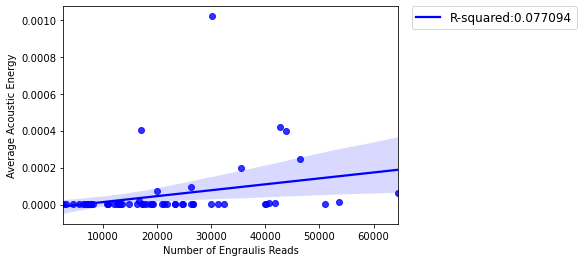

R-squared: 0.222787
../figures/Anchovy_Acoustic/CN19S_12S_avgDEIMOS_linres_log10avg_Engraulis_100m.pdf


<ipython-input-17-0eacb4ec27cf>:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
<ipython-input-17-0eacb4ec27cf>:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


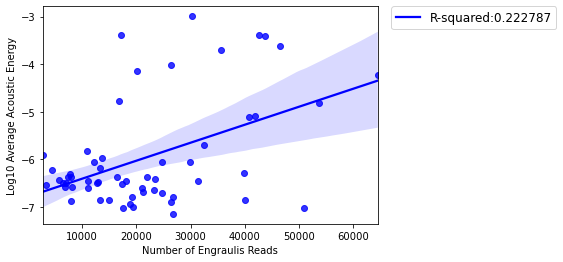

In [17]:
print(markers[0])
levels = list(taxas[0])
df = pd.concat([otus[0], taxas[0]], axis=1)
#sum all fish and shark reads
#df = df.loc[df['Class'].isin(['Actinopteri', 'Chondrichthyes'])]
df = df.loc[df['Genus'].isin(['Engraulis'])==True]
print(df['Genus'].unique())
df = df.groupby('Genus').sum()


df = df.T
df = pd.concat([df, metas[0][['depth', 'FilterID']]], axis=1)
df = df.join(DEIM, on='FilterID')
df = df.loc[df['depth']<=200]
print(list(DEIM))
df = df.loc[df['Average sampled energy'].isna()==False]


import seaborn as sns
from scipy import stats

df = df.loc[df['Average sampled energy']>0]
df = df.loc[df['Engraulis']>500]
df['lognorm_avg'] = np.log10(df['Average sampled energy'])
df['lognorm_chordata'] = np.log10(df['Engraulis'])
df = df.sort_values('lognorm_avg')
df = df.loc[df['lognorm_avg']!=0]
df = df.loc[df['lognorm_avg'].isna()==False]
### no log

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Engraulis'],df['Average sampled energy'])
res = stats.linregress(df['Engraulis'],df['Average sampled energy'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
# ax = sns.regplot(x="Chordata", y="lognorm_avg", data=df, color='b', 
#  line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax = sns.regplot(x="Engraulis", y="Average sampled energy", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Number of Engraulis Reads')
ax.set_ylabel('Average Acoustic Energy')
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_Avg_Engraulis_100m.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()



#####   log scale

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Engraulis'],df['lognorm_avg'])
res = stats.linregress(df['Engraulis'],df['lognorm_avg'])
print(f"R-squared: {res.rvalue**2:.6f}")


# use line_kws to set line label for legend
# ax = sns.regplot(x="Chordata", y="lognorm_avg", data=df, color='b', 
#  line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax = sns.regplot(x="Engraulis", y="lognorm_avg", data=df, color='b', 
 line_kws={'label':f"R-squared:{res.rvalue**2:.6f}"})
# plot legend
ax.legend()

ax.set_xlabel('Number of Engraulis Reads')
ax.set_ylabel('Log10 Average Acoustic Energy')
plt.legend(bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='12')

#save
filename=plot_dir +'CN19S_12S_avgDEIMOS_linres_log10avg_Engraulis_100m.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()